In [1]:
#setup
data_dir='../../Data/Weather'
file_index='SSSBSBBS'
meas='SNWD'

# Reconstruction using top eigen-vectors
For measurement = {{meas}}

## Load the required libraries

In [2]:
# Enable automiatic reload of libraries
#%load_ext autoreload
#%autoreload 2 # means that all modules are reloaded before every command

In [3]:
%pylab inline
import numpy as np

import findspark
findspark.init()

import sys
sys.path.append('./lib')

from numpy_pack import packArray,unpackArray

from Eigen_decomp import Eigen_decomp
from YearPlotter import YearPlotter
from recon_plot import recon_plot

from import_modules import import_modules,modules
import_modules(modules)

from ipywidgets import interactive,widgets

Populating the interactive namespace from numpy and matplotlib
    pandas as    pd 	version=0.20.1 	required version>=0.19.2
     numpy as    np 	version=1.12.1 	required version>=1.12.0
   sklearn as    sk 	version=0.18.1 	required version>=0.18.1
    urllib as urllib 	version=1.17 	required version>=1.17
   pyspark as pyspark 	version=2.1.0+hadoop2.7 	required version>=2.1.0
ipywidgets as ipywidgets 	version=6.0.0 	required version>=6.0.0


In [4]:
from pyspark import SparkContext
#sc.stop()

sc = SparkContext(master="local[3]",pyFiles=['lib/numpy_pack.py','lib/spark_PCA.py','lib/computeStats.py','lib/recon_plot.py','lib/Eigen_decomp.py'])

from pyspark import SparkContext
from pyspark.sql import *
sqlContext = SQLContext(sc)

## Read Statistics File

In [5]:
from pickle import load

#read statistics
filename=data_dir+'/STAT_%s.pickle'%file_index
STAT,STAT_Descriptions = load(open(filename,'rb'))
measurements=STAT.keys()
print 'keys from STAT=',measurements

keys from STAT= ['TMIN', 'TOBS', 'TMAX', 'SNOW', 'SNWD', 'PRCP']


## Read data file into a spark DataFrame
We focus on the snow-depth records, because the eigen-vectors for them make sense.

In [6]:
#read data
filename=data_dir+'/decon_%s_%s.parquet'%(file_index,meas)
df_in=sqlContext.read.parquet(filename)
#filter in 
df=df_in.filter(df_in.measurement==meas)
df.show(5)

+------------------+------------------+-------------------+-------------------+---------+--------+--------+---------+-----------+-------------------+-------------------+-------------------+-------------------+------------------+-----------+------------+------+--------------------+------+
|           coeff_1|           coeff_2|            coeff_3|            coeff_4|elevation|   label|latitude|longitude|measurement|              res_1|              res_2|              res_3|              res_4|          res_mean|    station|   total_var|undefs|              vector|  year|
+------------------+------------------+-------------------+-------------------+---------+--------+--------+---------+-----------+-------------------+-------------------+-------------------+-------------------+------------------+-----------+------------+------+--------------------+------+
| 8479.193692677072|2685.5045147058017|  1675.980173961427|-1122.0007863393103|   1934.0|SSSBSBBS|   38.85|-120.0167|       SNWD| 0.1

### Plot Mean and Eigenvecs

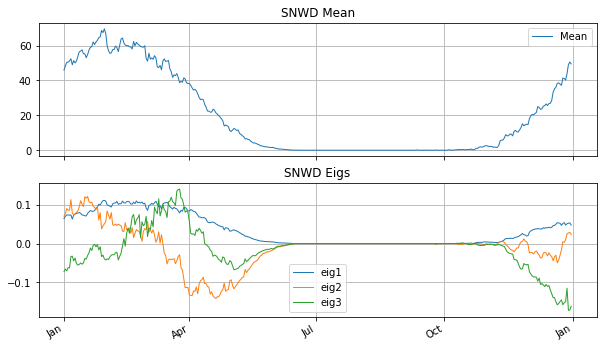

In [7]:
m=meas
fig,axes=plt.subplots(2,1, sharex='col', sharey='row',figsize=(10,6));
k=3
EigVec=np.matrix(STAT[m]['eigvec'][:,:k])
Mean=STAT[m]['Mean']
YearPlotter().plot(Mean,fig,axes[0],label='Mean',title=m+' Mean')
YearPlotter().plot(EigVec,fig,axes[1],title=m+' Eigs',labels=['eig'+str(i+1) for i in range(k)])

### plot the percent of residual variance on average

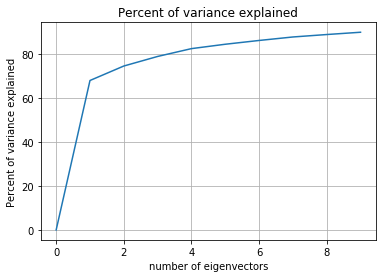

In [8]:
#  x=0 in the graphs below correspond to the fraction of the variance explained by the mean alone
#  x=1,2,3,... are the residuals for eig1, eig1+eig2, eig1+eig2+eig3 ...
fig,ax=plt.subplots(1,1);
eigvals=STAT[m]['eigval']; eigvals/=sum(eigvals); cumvar=cumsum(eigvals); cumvar=100*np.insert(cumvar,0,0)
ax.plot(cumvar[:10]); 
ax.grid(); 
ax.set_ylabel('Percent of variance explained')
ax.set_xlabel('number of eigenvectors')
ax.set_title('Percent of variance explained');

### How well-explained are the vectors in this collection?

To answer this question we extract all of the values of `res_3` which is the residual variance after the Mean and the 
first two Eigen-vectors have been subtracted out. We rely here on the fact that `df3` is already sorted according to `res_3`

In [9]:
# A function for plotting the CDF of a given feature
def plot_CDF(df,feat):
    rows=df.select(feat).sort(feat).collect()
    vals=[r[feat] for r in rows]
    P=np.arange(0,1,1./(len(vals)))
    while len(vals)< len(P):
        vals=[vals[0]]+vals
    plot(vals,P)
    title('cumulative distribution of '+feat)
    ylabel('fraction of instances')
    xlabel(feat)
    grid()
    

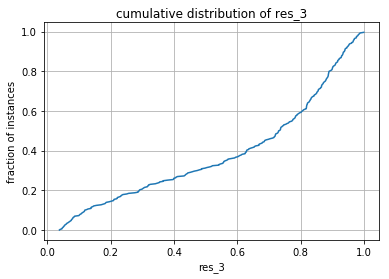

In [10]:
plot_CDF(df,'res_3')

In [11]:
rows=df.rdd.map(lambda row:(row.station,row.year,unpackArray(row['vector'],np.float16))).collect()
rows[0][:2]

(u'USC00045572', 1956.0)

In [12]:
days=set([r[1] for r in rows])
miny=min(days)
maxy=max(days)
record_len=int((maxy-miny+1)*365)
record_len

35770

In [13]:
## combine the measurements for each station into a single long array with an entry for each day of each day
All={}  # a dictionary with a numpy array for each day of each day
i=0
for station,day,vector in rows:
    i+=1; 
    # if i%1000==0: print i,len(All)
    if not station in All:
        a=np.zeros(record_len)
        a.fill(np.nan)
        All[station]=a
    loc = int((day-miny)*365)
    All[station][loc:loc+365]=vector

In [14]:
from datetime import date
d=datetime.date(int(miny), month=1, day=1)
start=d.toordinal()
dates=[date.fromordinal(i) for i in range(start,start+record_len)]

In [15]:
for station in All:
    print station, np.count_nonzero(~np.isnan(All[station]))

USC00045571 1440
USC00048928 1063
USC00045356 3521
USC00268977 340
USC00265191 1450
USC00269229 365
USC00267806 4191
USC00043134 4156
USC00049775 12258
USC00041909 362
USC00049582 332
USC00260955 2134
USC00267640 993
USC00049105 3682
USC00041277 5766
USC00262119 4021
USC00049382 725
USC00263515 363
USC00046962 339
USC00266746 2157
USC00042671 2089
USC00046597 9078
USC00045572 4609
USC00047689 8663
USC00268202 730
USC00043384 2719
USC00048760 334
USC00043381 1779
USC00045909 2498
USC00041911 342
USC00040943 13921
USC00268186 365
USC00265168 730
USC00041075 2059
USC00041072 10252
USC00263205 6161


In [16]:
Stations=sorted(All.keys())
A=[]
for station in Stations:
    A.append(All[station])

day_station_table=np.hstack([A])
print shape(day_station_table)

(36, 35770)


In [17]:
def RMS(Mat):
    return np.sqrt(np.nanmean(Mat**2))

mean_by_day=np.nanmean(day_station_table,axis=0)
mean_by_station=np.nanmean(day_station_table,axis=1)
tbl_minus_day = day_station_table-mean_by_day
tbl_minus_station = (day_station_table.transpose()-mean_by_station).transpose()

print 'total RMS                   = ',RMS(day_station_table)
print 'RMS removing mean-by-station= ',RMS(tbl_minus_station)
print 'RMS removing mean-by-day   = ',RMS(tbl_minus_day)

total RMS                   =  249.164714315
RMS removing mean-by-station=  215.48279354
RMS removing mean-by-day   =  183.598503477


/home/umyta/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:4: RuntimeWarning: Mean of empty slice


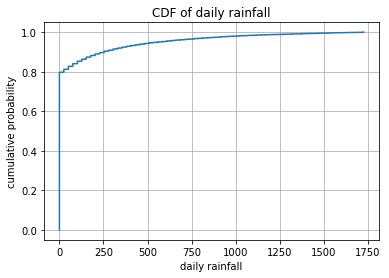

In [18]:
RT=day_station_table
F=RT.flatten()
NN=F[~np.isnan(F)]

NN.sort()
P=np.arange(0.,1 - 1./len(NN),1./len(NN))
plot(NN,P)
grid()
title('CDF of daily rainfall')
xlabel('daily rainfall')
ylabel('cumulative probability')

### Conclusions
It is likely to be hard to find correlations between the **amount** of rain on the same day in different stations. Because amounts of rain vary a lot between even close locations. It is more reasonable to try to compare whether or not it rained on the same day in different stations. As we see from the graph above, in our region it rains in about one third of the days.

### measuring statistical significance
We want to find a statistical test for rejecting the null hypothesis that says that the rainfall in the two locations is independent.

Using the inner product is too noisy, because you multiply the rainfall on the same day in two locations and that product can be very large - leading to a large variance and poor ability to discriminate.

An alternative is to ignore the amount of rain, and just ask whether it rained in both locations. We can then compute the probability associated with the number of overlaps under the null hypothesis.

Fix two stations. We restrict our attention to the days for which we have measurements for both stations, and define the following notation:
* $m$ : the total number of days (for which we have measurements for both stations).
* $n_1$ : the number of days that it rained on station 1
* $n_2$ : the number of days that it rained on station 2
* $l$ : the number of days that it rained on both stations.

We want to calculate the probability that the number of overlap days is $l$ given $m,n_1,n_2$.

The answer is:
$$
P = {m \choose l,n_1-l,n_2-l,m-n_1-n_2+l} /{m \choose n_1}{m \choose n_2}
$$

Where
$$
{m \choose l,n_1-l,n_2-l,m-n_1-n_2+l} = \frac{m!}{l! (n_1-l)! (n_2-l)! (m-n_1-n_2+l)!}
$$

We use the fact that $\Gamma(n+1) = n!$ and denote $G(n) \doteq \log \Gamma(n+1)$
$$
\log P = \left[G(m) - G(l) -G(n_1-l) -G(n_2-l) -G(m-n_1-n_2+l) \right] - 
\left[G(m)-G(n_1)-G(m-n_1)\right] - \left[G(m)-G(n_2)-G(m-n_2)\right]
$$
Which slightly simplifies to 
$$
\log P = -G(l) -G(n_1-l) -G(n_2-l) -G(m-n_1-n_2+l) - G(m)+G(n_1)+G(m-n_1) +G(n_2)+G(m-n_2)
$$

The log probability scales with $m$ the length of the overlap. So to get a per-day significance we consider $
\frac{1}{m} \log P $

In [19]:
from scipy.special import gammaln,factorial
#for i in range(10):
#    print exp(gammaln(i+1))-factorial(i)
def G(n):
    return gammaln(n+1)
def LogProb(m,l,n1,n2):
    logP=-G(l)-G(n1-l)-G(n2-l)-G(m-n1-n2+l)-G(m)+G(n1)+G(m-n1)+G(n2)+G(m-n2)
    return logP/m
exp(LogProb(1000,0,500,500))

0.501843349103545

In [20]:
#USC00193270 21482
#USC00193702 28237
X=copy(All['USC00045571'])
Y=copy(All['USC00048928'])
print sum(~np.isnan(X))
print sum(~np.isnan(Y))
X[np.isnan(Y)]=np.nan
Y[np.isnan(X)]=np.nan
print sum(~np.isnan(X))
print sum(~np.isnan(Y))


1440
1063
329
329


In [21]:
def computeLogProb(X,Y):
    X[np.isnan(Y)]=np.nan
    Y[np.isnan(X)]=np.nan
    G=~isnan(X)
    m=sum(G)
    XG=X[G]>0
    YG=Y[G]>0
    n1=sum(XG)
    n2=sum(YG)
    l=sum(XG*YG)
    logprob=LogProb(m,l,n1,n2)
    # print 'm=%d,l=%d,n1=%d,n2=%d,LogPval=%f'%(m,l,n1,n2,logprob)
    return logprob,m
print computeLogProb(X,Y)

(-0.028543323898784754, 329)


### calculate the normalized log probability for each pair of stations.

In [22]:
L=len(Stations)
Pvals=np.zeros([L,L])
Length=np.zeros([L,L])
P_norm=np.zeros([L,L])
for i in range(L):
    print i,
    for j in range(L):
        if i==j: 
            P_norm[i,j]=-0.4
            continue
        X=copy(All[Stations[i]])
        Y=copy(All[Stations[j]])
        P_norm[i,j],Length[i,j]=computeLogProb(X,Y)
        if Length[i,j]<200:
            P_norm[i,j]=np.nan

            

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16

/home/umyta/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:8: RuntimeWarning: invalid value encountered in double_scalars


 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35


In [23]:
print Pvals[:2,:2]
print Length[:2,:2]
print P_norm[:2,:2]

[[ 0.  0.]
 [ 0.  0.]]
[[    0.  6956.]
 [ 6956.     0.]]
[[-0.4        -0.21439787]
 [-0.21439787 -0.4       ]]


(1296,) (572,)


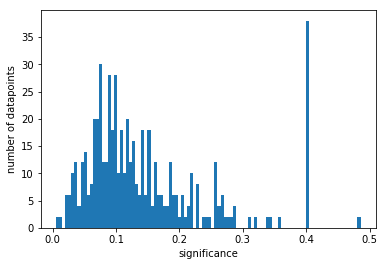

In [34]:
A=P_norm.flatten();
B=A[~isnan(A)]
print A.shape,B.shape
plt.hist(-B,bins=100);
plt.xlabel('significance')
plt.ylabel('number of datapoints')
plt.figure()
plt.savefig('my_figures/SNWD_prob_hist.png')

In [25]:
def showmat(mat):
    fig,axes=plt.subplots(1,1,figsize=(10,10))
    axes.imshow(mat, cmap=plt.cm.gray)

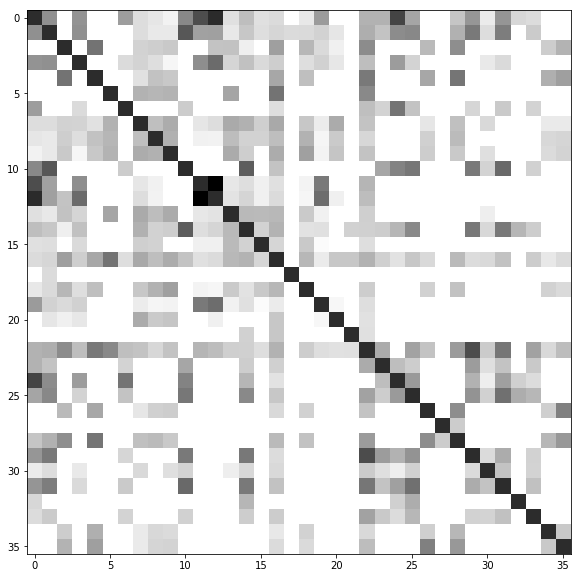

In [26]:
showmat(P_norm)

### Finding structure in the rependency matrix.
The matrix above shows, for each pair of stations, the normalized log probability that the overlap in rain days is random.

We see immediately the first 2 stations are highly correlatedwith each other. 

To find more correlations we use SVD (the term PCA is reserved for decomposition of the covariance matrix). As we shall see that the top 10 eigenvectors explain about 80% of the square magnitude of the matrix.

In [35]:
print 'A group of very correlated stations is:',All.keys()[:2]

A group of very correlated stations is: [u'USC00045571', u'USC00048928']


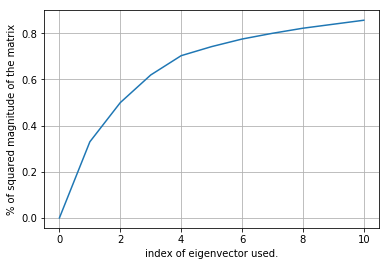

In [38]:
from sklearn.decomposition import PCA
P_norm0 = np.nan_to_num(P_norm)
n_comp=10
pca = PCA(n_components=n_comp, svd_solver='full')
pca.fit(P_norm0)     
#print(pca.explained_variance_)
Var_explained=pca.explained_variance_ratio_
plot(insert(cumsum(Var_explained),0,0))
xlabel('index of eigenvector used.')
ylabel('% of squared magnitude of the matrix')
grid()

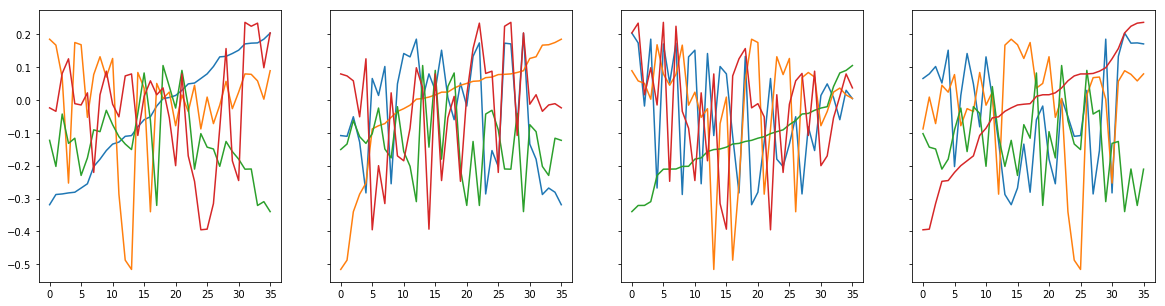

In [30]:
fig,axes=plt.subplots(1,4,figsize=(20,5),sharey='row');
L=list(pca.components_.transpose())
for i in range(4):
    X=sorted(L,key=lambda x:x[i]) 
    axes[i].plot(X);

In [31]:
def re_order_matrix(M,order):
    M_reord=M[order,:]
    M_reord=M_reord[:,order]
    return M_reord

[10 31 24  0 25]
[12 11 19  3  0]
[ 4 28 22  2 29]
[13  5  7 16  9]


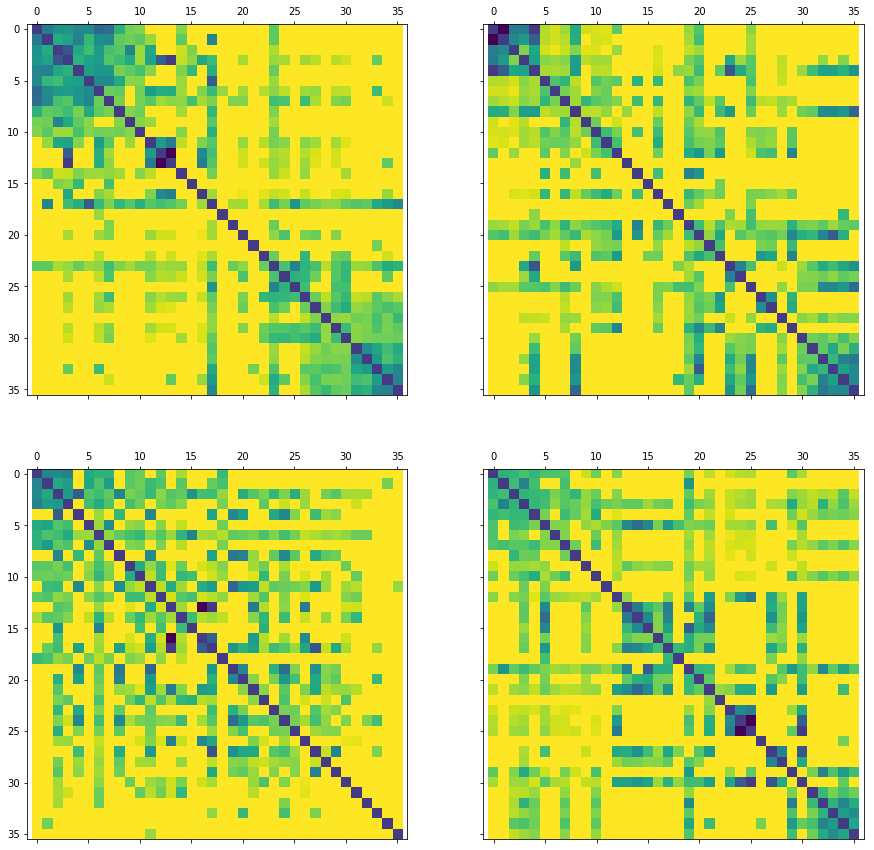

In [41]:
fig,axes=plt.subplots(2,2,figsize=(15,15),sharex='col',sharey='row');
i=0
for r in range(2):
    for c in range(2):
        order=np.argsort(pca.components_[i,:])
        P_norm_reord=re_order_matrix(P_norm0,order)
        print order[:5]
        axes[r,c].matshow(P_norm_reord)
        i+=1

In [47]:
print All.keys()[10]
print All.keys()[31]
print All.keys()[24]
print All.keys()[0]
print All.keys()[25]

USC00049582
USC00268186
USC00268202
USC00045571
USC00043384


### Explanation and possibe extensions
When we reorder the rows and columns of the matrix using one of the eigenvectors, the grouping of the 
stations becomes more evident. For example, consider the upper left corner of the scond matrix (The upper left one). The stations at positions 0-22 are clearly strongly correlated with each other. Even though there are some stations, in positions 15-18 or so, which are more related to each other than to the rest of this block.

This type of organization is called **Block Diagonal** and it typically reveals important structure such as grouping or clustering.

You might want to extract the sets of stations that form blocks for your region, and then plot them on the map to see their spatial relationship.

In [33]:
from pickle import dump
with open(data_dir+'/%s_residuals_PCA.pickle'%meas,'wb') as file:
    dump({'stations':All.keys(),
          'eigen-vecs':pca.components_},
        file)
    